# Supervised Prediction using Regression

- Created by Aman, J.

This notebook is an introduction to the machine learning concepts of clustering and preduction using regression. We will use the Building Data Genome Project data set to analyze electrical meter data from non-residential buildings.

This project has an open data set of 3,053 energy meters from 1,636 non-residential buildings with a range of two full years (2016 and 2017) at an hourly frequency (17,544 measurements per meter resulting in approximately 53.6 million measurements). 

## Using the Building Data Genome Project Data Set for Clustering and Regression Prediction

Let's use the lectrical meter data to create clusters of typical load profiles for analysis. First we can load our conventional packages

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib


Next let's load all the packages we will need for the clustering and regression analysis

In [2]:
import sklearn
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor

from scipy.cluster.vq import kmeans, vq, whiten
from scipy.spatial.distance import cdist
import numpy as np
from datetime import datetime


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
os.chdir("/content/gdrive/MyDrive/MIZZOU/_AT&T_Scripts/20221216_data")

## Load electricity data and weather data


In [5]:
df_prediction_data = pd.read_csv("/content/gdrive/MyDrive/MIZZOU/_AT&T_Scripts/20221216_data/SteelcaseStudio_Meter.csv", parse_dates=True, index_col='timestamp')

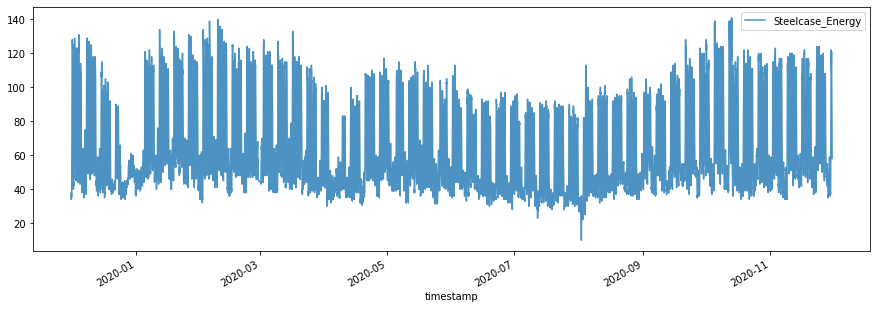

In [6]:
df_prediction_data.plot(alpha=0.8, figsize=(15, 5))

In [7]:
#os.chdir("/content/gdrive/MyDrive/MIZZOU/_AT&T_Scripts/weather_data")
weather_data = pd.read_csv("weather2020.csv", index_col='timestamp', parse_dates=True)

In [8]:
weather_hourly = weather_data.resample("H").mean()
weather_hourly_nooutlier = weather_hourly[weather_hourly > -40]
weather_hourly_nooutlier_nogaps = weather_hourly_nooutlier.fillna(method='ffill')

In [9]:
temperature = weather_hourly_nooutlier_nogaps["TemperatureC"]

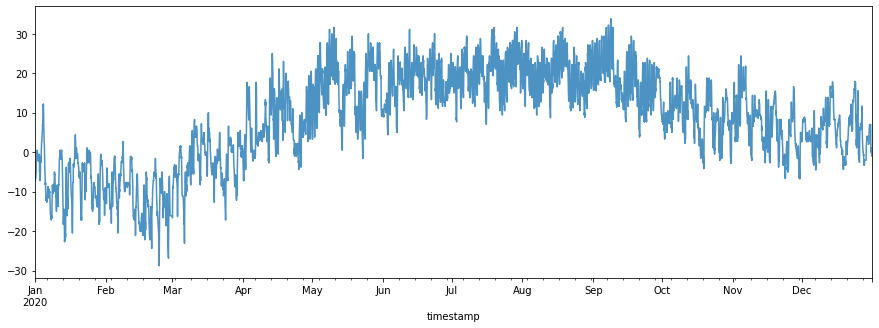

In [10]:
temperature.plot(alpha=0.8, figsize=(15, 5))

In [11]:
temperature

timestamp
2020-01-01 00:00:00   -7.2
2020-01-01 01:00:00   -6.6
2020-01-01 02:00:00   -6.6
2020-01-01 03:00:00   -6.6
2020-01-01 04:00:00   -6.6
                      ... 
2020-12-31 17:00:00   -1.0
2020-12-31 18:00:00   -1.0
2020-12-31 19:00:00   -1.0
2020-12-31 20:00:00   -1.0
2020-12-31 21:00:00   -1.0
Freq: H, Name: TemperatureC, Length: 8782, dtype: float64

## Create Train and Test Datasets for Supervsed Learning

With **supervised learning**, the model is given a set of data that will be used to **train** the model to predict a specific objectice. In this case, we will use a few simple time series features as well as outdoor air temperature to predict how much energy a building uses.

For this demonstration, we will use three months of data from April, May, and June to prediction July.

In [12]:
training_months = [4,5,6,7]
test_months = [7]

We can divide the data set by using the `datetime index` of the data frame and a function known as `.isin` to extract the months for the model

In [13]:
trainingdata = df_prediction_data[df_prediction_data.index.month.isin(training_months)]
testdata = df_prediction_data[df_prediction_data.index.month.isin(test_months)]


In [14]:
testdata

,Steelcase_Energy
timestamp,
2020-07-01 00:00:00,40.000000
2020-07-01 01:00:00,42.000000
2020-07-01 02:00:00,40.000000
2020-07-01 03:00:00,37.000000
2020-07-01 04:00:00,39.000000
...,...
2020-07-31 19:00:00,47.000000
2020-07-31 20:00:00,41.000000
2020-07-31 21:00:00,40.000000


In [15]:
trainingdata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2928 entries, 2020-04-01 00:00:00 to 2020-07-31 23:00:00
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Steelcase_Energy  2928 non-null   float64
dtypes: float64(1)
memory usage: 45.8 KB


In [16]:
testdata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 744 entries, 2020-07-01 00:00:00 to 2020-07-31 23:00:00
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Steelcase_Energy  744 non-null    float64
dtypes: float64(1)
memory usage: 11.6 KB


We can extract the training input data features that will go into the model and the training **label** data which is what are are targeting to predict. 

## Encoding Categorical Variables 

We use the pandas `.get_dummies()` function to change the temporal variables of *time of day* and *day of week* into categories that the model can use more effectively. This process is known as [enconding](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/)

In [17]:
train_features = pd.concat([pd.get_dummies(trainingdata.index.hour), 
                                     pd.get_dummies(trainingdata.index.dayofweek), 
                                     pd.DataFrame(temperature[temperature.index.month.isin(training_months)].values)], axis=1).dropna()


In [18]:
train_features.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,0,1,2,3,4,5,6,0
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,-5.5
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,-6.1
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,-7.2
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,-6.6
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,-7.2


## Train a K-Neighbor Regressor Model

This model was chosen after following the process in the cheat sheet until a model that worked and provided good results was found.

In [19]:
model = KNeighborsRegressor().fit(np.array(train_features), np.array(trainingdata.values));


In [20]:
test_features = np.array(pd.concat([pd.get_dummies(testdata.index.hour),
                                    pd.get_dummies(testdata.index.dayofweek),
                                    pd.DataFrame(temperature[temperature.index.month.isin(test_months)].values)], axis=1).dropna())



## Use the Model to predict for the *Test* period

Then the model is given the `test_features` from the period which we want to predict. We can then merge those results and see how the model did

In [21]:
predictions = model.predict(test_features)

In [22]:
predicted_vs_actual = pd.concat([testdata, pd.DataFrame(predictions, index=testdata.index)], axis=1)


In [23]:
predicted_vs_actual.columns = ["Actual", "Predicted"]

In [24]:
predicted_vs_actual.head()

,Actual,Predicted
timestamp,,
2020-07-01 00:00:00,40.0,36.6
2020-07-01 01:00:00,42.0,37.0
2020-07-01 02:00:00,40.0,40.8
2020-07-01 03:00:00,37.0,41.6
2020-07-01 04:00:00,39.0,40.0


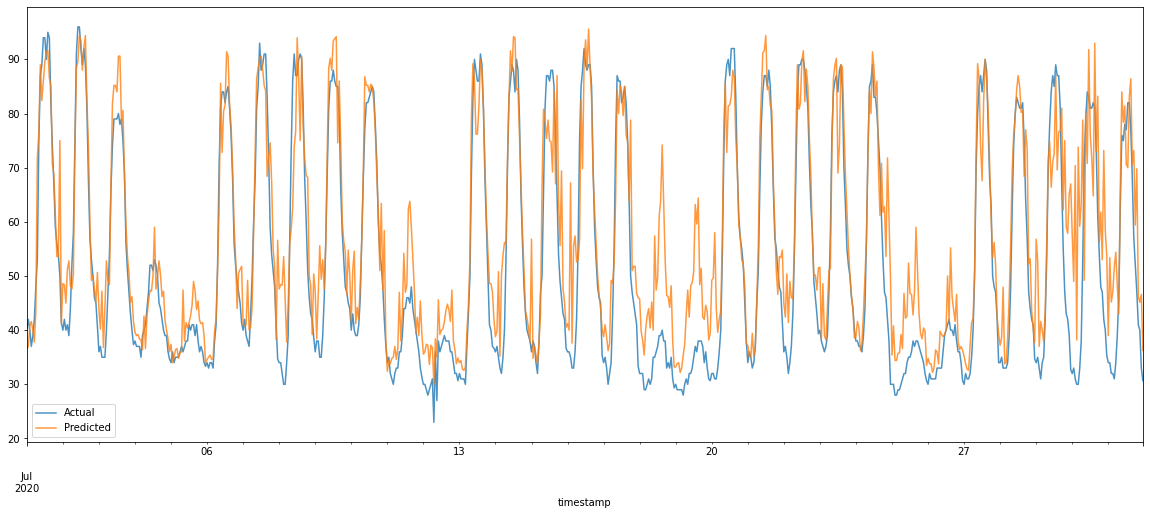

In [25]:
predicted_vs_actual.plot(alpha=0.8, figsize=(20, 8))

## Experiment with accuracy and visualization

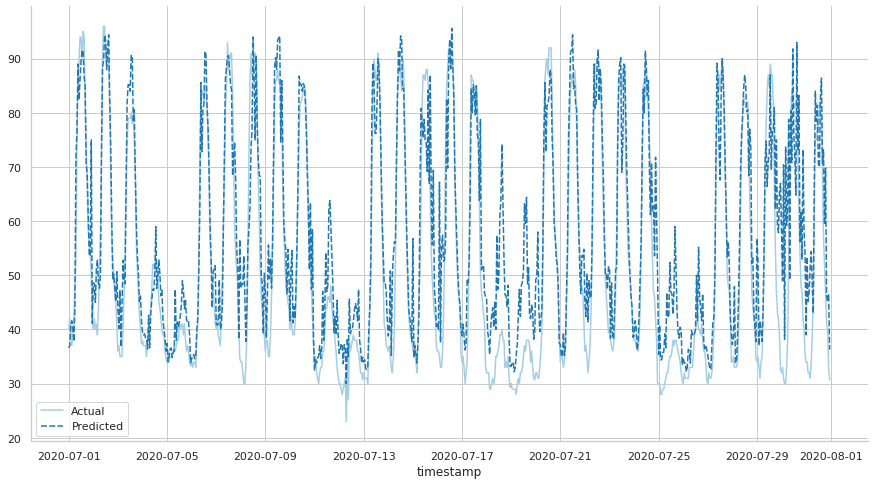

In [26]:
import seaborn as sns
#sns.set(rc = {'figure.figsize':(15,8)})
plt.figure(figsize = (15,8))
#sns.color_palette("flare")
sns.set(style="whitegrid")
p = sns.lineplot(data=predicted_vs_actual, palette="Paired", linewidth=1.5)
sns.despine()


In [27]:
predicted_vs_actual

,Actual,Predicted
timestamp,,
2020-07-01 00:00:00,40.000000,36.600000
2020-07-01 01:00:00,42.000000,37.000000
2020-07-01 02:00:00,40.000000,40.800000
2020-07-01 03:00:00,37.000000,41.600000
2020-07-01 04:00:00,39.000000,40.000000
...,...,...
2020-07-31 19:00:00,47.000000,69.800000
2020-07-31 20:00:00,41.000000,46.200000
2020-07-31 21:00:00,40.000000,45.133333


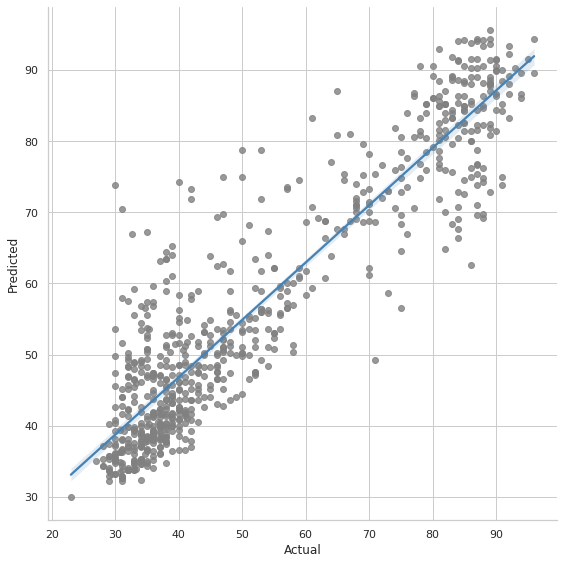

In [28]:
from seaborn.widgets import color_palette
sns.set(style="whitegrid")
sns.lmplot(x='Actual', y='Predicted', line_kws={'color': 'steelblue'}, scatter_kws={"color": "grey"}, height=8, data=predicted_vs_actual, aspect=1)

In [29]:
trainingdata.columns = ["Actual"]

In [30]:
predicted_vs_actual_plus_training = pd.concat([trainingdata, predicted_vs_actual], sort=True)

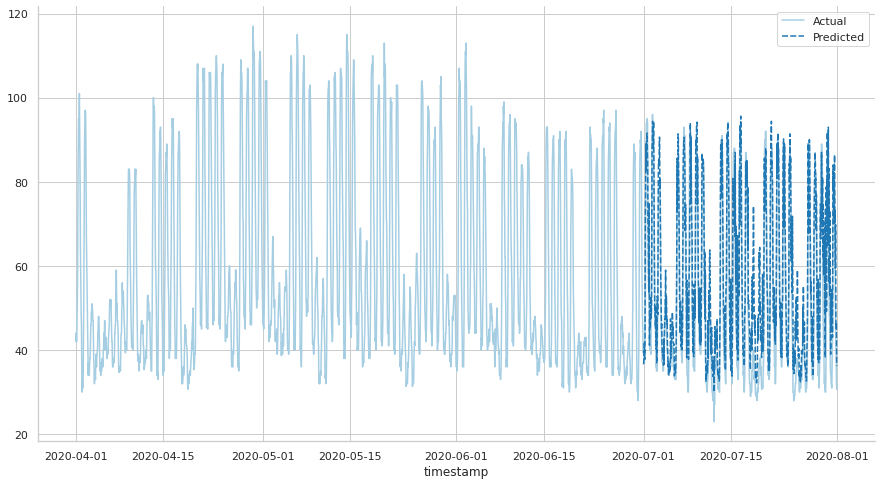

In [31]:
#predicted_vs_actual_plus_training.plot(alpha=1, figsize=(20, 8))

plt.figure(figsize = (15,8))
sns.set(style="whitegrid")
p = sns.lineplot(data=predicted_vs_actual_plus_training, palette="Paired", linewidth=1.5)
sns.despine()

## Experiment with Regression evaluation metrics

In order to understand quanitatively how the model performed, we can use various evaluation metrics to understand how well the model compared to reality. 

In this situation, let's use the error metric [Mean Absolute Percentage Error (MAPE)](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error) 

In [32]:
predicted_results = predicted_vs_actual['Predicted']
actual_results = predicted_vs_actual['Actual']


In [35]:
import math
# Calculate the absolute errors
errors = abs(predicted_results - actual_results)
# Calculate mean absolute percentage error (MAPE) and add to list
MAPE = 100 * np.mean((errors / actual_results ))
mae=metrics.mean_absolute_error(predicted_results, actual_results)
mse=metrics.mean_squared_error(predicted_results, actual_results)
rmse = np.sqrt(mse)
R_square = metrics.r2_score(predicted_results, actual_results)
R_square = metrics.r2_score(predicted_results, actual_results)
Rsqr = math.sqrt(R_square)


# Printing the metrics
print('MAPE:',MAPE)
print('R2 square:',R_square)
print('MAE: ', mae)
print('MSE: ', mse)
print('RMSE: ', rmse)
#print('R sqr: ', Rsqr)

MAPE: 15.692808871348468
R2 square: 0.7347535626881344
MAE:  6.783691756258066
MSE:  88.63801672611052
RMSE:  9.414776509620955
